# 개요
- 데이터셋 명 : 흉부 엑스선 이미지(정상 혹은 폐렴 이미지)
- 미션 : 흉부 엑스선 이미지를 기반으로 정상인지 폐렴인지 판단
- 문제 유형 : 이진 분류
- 평가 지표 : 정확도, 재현율, F1 score
- 결과 제출이 없음
- [URL](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.style.use('seaborn')
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format='retina'

/tmp/ipykernel_82614/752242914.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 데이터셋 이해

<img width= 500, src="../img/ch13_fig01.png">

# 탐색적 데이터 분석
## 데이터 둘러보기

In [1]:
data_path = '/home/restful3/datasets_local/chest_xray/'

train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [2]:
from glob import glob

print(f'훈련 데이터 개수 {len(glob(train_path + "*/*"))}')
print(f'검증 데이터 개수 {len(glob(valid_path + "*/*"))}') # 검증 데이터의 수가 너무 적다
print(f'테스트 데이터 개수 {len(glob(test_path + "*/*"))}')

훈련 데이터 개수 5216
검증 데이터 개수 16
테스트 데이터 개수 624


In [3]:
all_normal_imgs = []
all_pneumonia_imgs = []

for cat in ['train/', 'val/', 'test/']:
    data_cat_path = data_path + cat
    
    normal_imgs = glob(data_cat_path+'NORMAL/*')
    pneumonia_imgs = glob(data_cat_path+'PNEUMONIA/*')    
    
    all_normal_imgs.extend(normal_imgs)
    all_pneumonia_imgs.extend(pneumonia_imgs)    
    
print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}')    # 정상 이미지의 수가 되려 적다
print(f'폐렴 흉부 이미지 개수 : {len(all_pneumonia_imgs)}')    

정상 흉부 이미지 개수 : 1583
폐렴 흉부 이미지 개수 : 4273


## 데이터 시각화
### 타깃값 분포

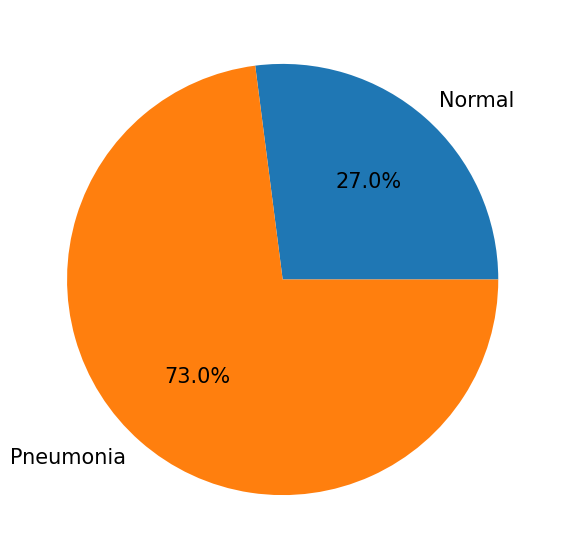

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
plt.figure(figsize=(7,7))

label = ['Normal', 'Pneumonia']

plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)],
       labels = label, autopct='%.1f%%');

### 이미지 출력

In [5]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3):
    assert len(img_paths) <= rows*cols # 이미지의 행/열 개수 보다 많은 수의 이미지가 들어오면 오류 발생
    
    mpl.rc('font', size=8)
    plt.figure(figsize=(15, 8))
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치
    
    # 이미지 출력
    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path) # 이미지 파일 읽기
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

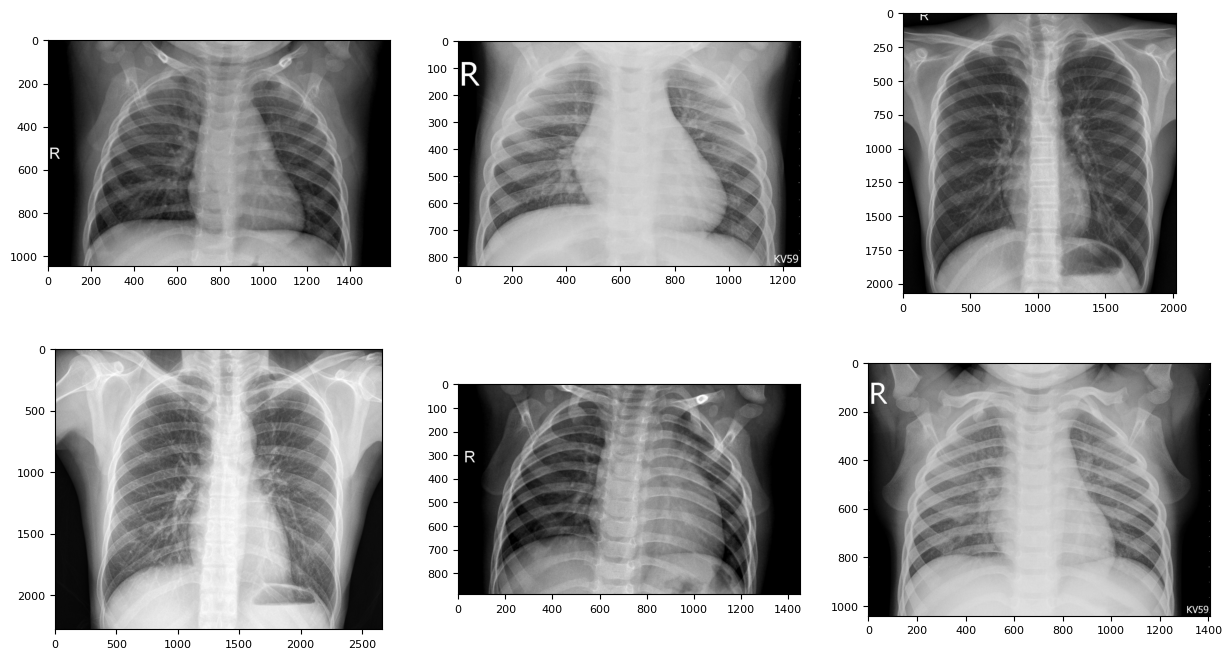

In [6]:
num_of_imgs = 6

# 정상인 이미지 출력
normal_img_paths = all_normal_imgs[-num_of_imgs:]
show_image(normal_img_paths)

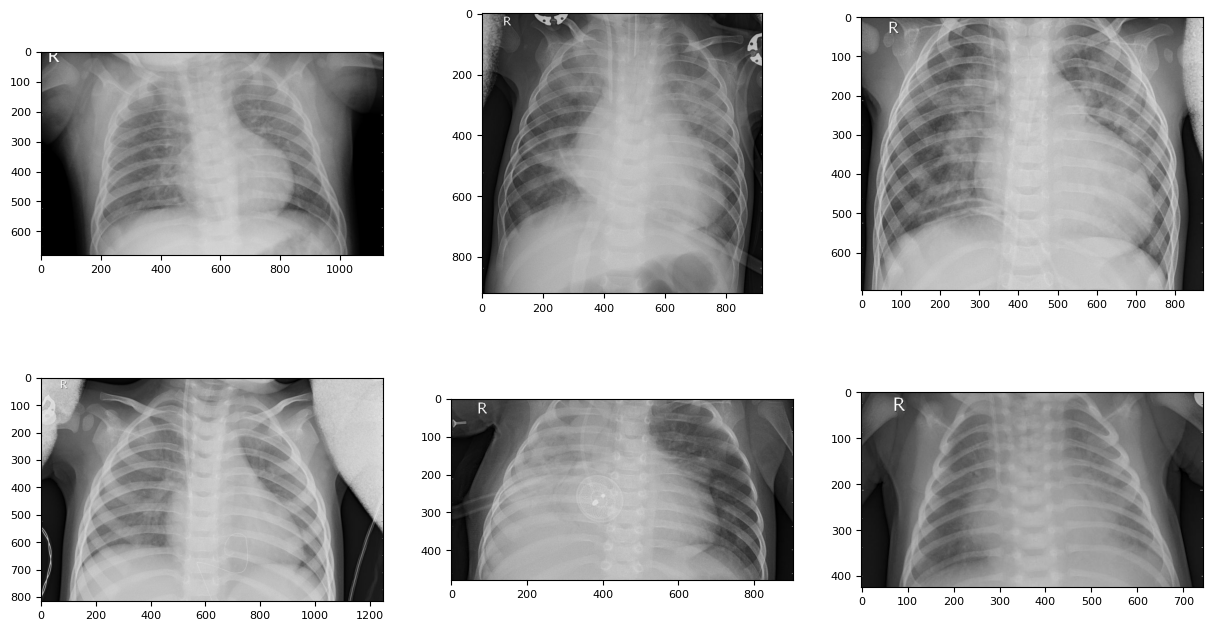

In [7]:
# 폐렴 이미지 출력
pneumonia_img_paths = all_pneumonia_imgs[-num_of_imgs:]
show_image(pneumonia_img_paths)

# 분석 정리 및 모델링 전략
## 분석 정리
- 검증 데이터를 훈련 데이터와 별도로 제공, 훈련 데이터에서 따로 추출 불필요
- 주어진 파일이 csv 형식이 아님
- 검증 데이터가 너무 적어, 지나치게 검증 데이터 신뢰 하지 않도록
- 타깃값이 같은 이미지끼리 디랙토리 구조로 구분
- 제공된 이미지의 크기가 제각각, 일정하게 크기 맞춰 줘야
## 모델링 전략
- 앞장과의 차별점
    - 베이스라인 모델링 때 훈련과 예측 단계를 함수로 묶어 성능 개선 때 재활용
    - efficientnet의 여러 버전 활용
- 베이스라인 모델
    - 데이터 증강 : 다양한 변환기
    - 신경망 모델 : 사전 훈련 모델(efficientnet-b0)
    - 옵티마이저 : Adam
    - 훈련 및 예측 : 각 단계의 코드를 함수로 제작
- 성능 개선
    - 데이터 증강 : 베이스라인과 동일
    - 신경망 구조 : efficeintnet-b1, b2, b3의 앙상블
    - 옵티마이저 : AdamW
    - 훈련 및 예측 : 베이스라인 때 만든 함수 활용

# 베이스라인 모델

<img src='../img/ch13_fig02.png'>

- 12장과의 다른 점
    - 데이터 불러 오는 과정이 다름
    - 데이터 준비 시 '데이터셋 클래스'를 따로 정의 하지 않음
    - 가장 단순한 efficientnet 사용
    - 훈련 과정과 예측 과정을 함수로 정의

## 시드값 고정 및 GPU 장비 설정
### 시드값 고정

In [8]:
import torch
import random
import numpy as np
import os

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

### GPU 장비 설정

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

<img src='../img/ch13_fig03.png'>

- ImageFolder 라는 데이터셋 생성기 사용

In [10]:
data_path = '/home/restful3/datasets_local/chest_xray/'

train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

### 데이터 증강을 위한 이미지 변환기 정의
- ImageFolder를 사용하기 위해 12장에서 사용한 albumentations를 사용하지 않음

In [11]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.CenterCrop(180),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.CenterCrop(180),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                        (0.229, 0.224, 0.225))    
])

### 데이터셋 및 데이터 로더 생성

<img width=700, src='../img/ch13_fig04.png'>

- ImageFolder()는 root 파라미터로 전달된 경로에 이미지들로 바로 데이터셋을 만든다
- ImageFolder()에 albumentations로 만든 변환기를 전달 하면 오류 발생

In [12]:
from torchvision.datasets import ImageFolder

datasets_train = ImageFolder(root=train_path, transform=transform_train)
datasets_valid = ImageFolder(root=valid_path, transform=transform_test)

- 멀티프로세싱을 위한 시드값 고정

In [13]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [14]:
from torch.utils.data import DataLoader

batch_size=8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, 
                         shuffle=True, worker_init_fn=seed_worker,
                         generator=g, num_workers=8)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=4)

## 모델 생성

- 책과는 다르게, pytorch 에서 기본 제공하는 efficeintnet 사전 학습 모델 사용

In [15]:
import torchvision
import torch.nn as nn

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model = model.to(device)

In [16]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


- 최종 분류 class의 수를 2로 변경

In [17]:
#(4x2560 and 1280x4)
model.classifier = torch.nn.Sequential(
    nn.Dropout(0.5, inplace=True), 
    nn.Linear(in_features=1280,
              out_features=2)
)

print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [18]:
print(f'모델 파라미터 개수 : {sum(param.numel() for param in model.parameters())}')

모델 파라미터 개수 : 4010110


## 모델 훈련 및 성능 검증
### 손실 함수와 옵티마이저 설정

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### 훈련 함수 작성 1 - 뼈대

<img width=700, src="../img/ch13_fig05.png">

In [21]:
def train(model, loader_train, loader_valid, criterion, optimizer, 
         scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    # 총 에폭 만큼 반복
    for epoch in range(epochs):
        # [훈련]:미니배치 단위로 훈련
        for images, labels in tqdm(loader_train):
            # 기울기 초기화
            # 순전파
            # 손실값 계산 (훈련 데이터용)
            # 역전파
            # 가중치 갱신
            # 학습률 갱신
            pass
        # [검증]:미니배치 단위로 검증
        for images, labels in loader_valid:
            # 순전파
            # 손실값 계산 (검증 데이터용)
            pass
        
        # [최적 모델 가중치 찾기]
        # 현 에폭에서의 검증 데이터 손실값이 지금까지 중 가장 작다면
        # 현 에폭의 모델 가중치(현재 까지의 최적 모델 가중치) 저장
    return torch.load(save_file)# 최적 모델 가중치 반환

### 훈련 함수 작성 2 - 훈련

In [22]:
def train(model, loader_train, loader_valid, criterion, optimizer, 
         scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용)
    
    # 총 에폭 만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n ----------------')
        # [훈련]
        model.train() # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 최소화(훈련 데이터용)
        
        # 미니배치 단위로 반복 횟수 만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니베치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # 옵티마이저 내 기울기 초기화
            outputs = model(images) # 순전파
            loss = criterion(outputs, labels) # 손실값 계산 (훈련 데이터용)
            epochs_train_loss += loss.item() # 현재 배치에서의 손실 추가
            loss.backward() # 역전파
            optimizer.step() # 가중치 갱신
            if scheduler != None : # 스케줄러 학습률 갱신
                scheduler.step()
                
        print(f'훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')        
        # [검증]:미니배치 단위로 검증
        for images, labels in loader_valid:
            # 순전파
            # 손실값 계산 (검증 데이터용)
            pass
        
        # [최적 모델 가중치 찾기]
        # 현 에폭에서의 검증 데이터 손실값이 지금까지 중 가장 작다면
        # 현 에폭의 모델 가중치(현재 까지의 최적 모델 가중치) 저장
    return torch.load(save_file)# 최적 모델 가중치 반환

### 훈련 함수 작성 3 - 검증

In [23]:
def train(model, loader_train, loader_valid, criterion, optimizer, 
         scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용)
    
    # 총 에폭 만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n ----------------')
        # [훈련]
        model.train() # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 최소화(훈련 데이터용)
        
        # 미니배치 단위로 반복 횟수 만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니베치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # 옵티마이저 내 기울기 초기화
            outputs = model(images) # 순전파
            loss = criterion(outputs, labels) # 손실값 계산 (훈련 데이터용)
            epoch_train_loss += loss.item() # 현재 배치에서의 손실 추가
            loss.backward() # 역전파
            optimizer.step() # 가중치 갱신
            if scheduler != None : # 스케줄러 학습률 갱신
                scheduler.step()
                
        print(f'훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')        
        
        # [검증]
        model.eval() # 모델을 평가 상태로 설정
        epoch_valid_loss = 0 # 에폭별 손실값 초기화(검증 데이터용)
        preds_list = [] # 예측값 저자용 리스트
        true_list = [] # 실젯값 저장용 리스트
        
        with torch.no_grad(): #기울기 계산 비활성화
            # 하나의 에폭만큼의 데이터를 미니배치 단위로 검증
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)                
                outputs = model(images) # 순전파
                loss = criterion(outputs, labels) # 손실값 계산 (검증 데이터용)
                epoch_valid_loss += loss.item() # 현재 배치에서의 손실 추가                
                
                
                # 예측값 및 실젯값
                # preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # F1-score는 확률이 아닌 이산값(0 또는 1)필요
                preds = torch.argmax(outputs.cpu(), dim=1)
                true = labels.cpu().numpy()
                
                preds_list.extend(preds)
                true_list.extend(true)
        print(f'\t 검증 데이터 손실 값 : {epoch_valid_loss /  len(loader_valid):.4f}')
        # 평가지표 계산 (정확도, 재현율, f1 score)
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recal = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        print(f'\t정확도 : {val_accuracy:.4f} /  재현율 : {val_recal : .4f} / F1-score : {val_f1_score:4f}')
    return torch.load(save_file)# 최적 모델 가중치 반환

In [24]:
import torch

sample = torch.rand(4, 2)
sample

tensor([[0.0407, 0.0477],
        [0.5664, 0.1200],
        [0.8145, 0.4293],
        [0.5765, 0.2580]])

In [25]:
torch.max(sample, dim=1)

torch.return_types.max(
values=tensor([0.0477, 0.5664, 0.8145, 0.5765]),
indices=tensor([1, 0, 0, 0]))

In [26]:
torch.max(sample, dim=1)[1]

tensor([1, 0, 0, 0])

In [27]:
torch.argmax(sample, dim=1)

tensor([1, 0, 0, 0])

### 훈련 함수 작성 4 - 최적 모델 가중치 찾기

In [28]:
def train(model, loader_train, loader_valid, criterion, optimizer, 
         scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용)
    
    # 총 에폭 만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n ----------------')
        # [훈련]
        model.train() # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 최소화(훈련 데이터용)
        
        # 미니배치 단위로 반복 횟수 만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니베치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # 옵티마이저 내 기울기 초기화
            outputs = model(images) # 순전파
            loss = criterion(outputs, labels) # 손실값 계산 (훈련 데이터용)
            epoch_train_loss += loss.item() # 현재 배치에서의 손실 추가
            loss.backward() # 역전파
            optimizer.step() # 가중치 갱신
            if scheduler != None : # 스케줄러 학습률 갱신
                scheduler.step()
                
        print(f'훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')        
        
        # [검증]
        model.eval() # 모델을 평가 상태로 설정
        epoch_valid_loss = 0 # 에폭별 손실값 초기화(검증 데이터용)
        preds_list = [] # 예측값 저자용 리스트
        true_list = [] # 실젯값 저장용 리스트
        
        with torch.no_grad(): #기울기 계산 비활성화
            # 하나의 에폭만큼의 데이터를 미니배치 단위로 검증
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)                
                outputs = model(images) # 순전파
                loss = criterion(outputs, labels) # 손실값 계산 (검증 데이터용)
                epoch_valid_loss += loss.item() # 현재 배치에서의 손실 추가                
                
                
                # 예측값 및 실젯값
                # preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # F1-score는 확률이 아닌 이산값(0 또는 1)필요
                preds = torch.argmax(outputs.cpu(), dim=1)
                true = labels.cpu().numpy()
                
                preds_list.extend(preds)
                true_list.extend(true)
        print(f'\t 검증 데이터 손실 값 : {epoch_valid_loss /  len(loader_valid):.4f}')
        # 평가지표 계산 (정확도, 재현율, f1 score)
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recal = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        print(f'\t정확도 : {val_accuracy:.4f} /  재현율 : {val_recal : .4f} / F1-score : {val_f1_score:4f}')
        
        # [최적 모델 가중치 찾기]
        # 현 에폭에서이ㅡ 손실값이 최소 손실값 이하면 모델 가중치 저장
        if epoch_valid_loss <= valid_loss_min:
            print(f'\t ## 검증 데이터 손싥밧 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}) 모델 저장')
            
            # 모델 가중치를 파일로 저장
            torch.save(model.state_dict(), save_file)
            valid_loss_min = epoch_valid_loss
    return torch.load(save_file)# 최적 모델 가중치 반환

### 훈련 함수 전체 코드

In [29]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score # 재현율 계산 함수
from sklearn.metrics import f1_score # f1-score 계산 함수
from tqdm.notebook import tqdm

def train(model, loader_train, loader_valid, criterion, optimizer, 
         scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    model = model.to(device)
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용)
    
    # 총 에폭 만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n ----------------')
        
        #============================ [훈련] ============================
        model.train() # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 최소화(훈련 데이터용)
        
        # 미니배치 단위로 반복 횟수 만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니베치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # 옵티마이저 내 기울기 초기화
            outputs = model(images) # 순전파
            loss = criterion(outputs, labels) # 손실값 계산 (훈련 데이터용)
            epoch_train_loss += loss.item() # 현재 배치에서의 손실 추가
            loss.backward() # 역전파
            optimizer.step() # 가중치 갱신
            if scheduler != None : # 스케줄러 학습률 갱신
                scheduler.step()
                
        print(f'훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')        
        
        #============================ [검증] ============================
        model.eval() # 모델을 평가 상태로 설정
        epoch_valid_loss = 0 # 에폭별 손실값 초기화(검증 데이터용)
        preds_list = [] # 예측값 저장용 리스트
        true_list = [] # 실젯값 저장용 리스트
        
        with torch.no_grad(): #기울기 계산 비활성화
            # 하나의 에폭만큼의 데이터를 미니배치 단위로 검증
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)    
                
                outputs = model(images) # 순전파
                loss = criterion(outputs, labels) # 손실값 계산 (검증 데이터용)
                epoch_valid_loss += loss.item() # 현재 배치에서의 손실 추가                
                
                
                # 예측값 및 실젯값
                # preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # F1-score는 확률이 아닌 이산값(0 또는 1)필요
                preds = torch.argmax(outputs.cpu(), dim=1)
                true = labels.cpu().numpy()
                
                preds_list.extend(preds)
                true_list.extend(true)

        # 현재 에폭의 검증 완료        
        print(f'\t 검증 데이터 손실 값 : {epoch_valid_loss /  len(loader_valid):.4f}')
        # 평가지표 계산 (정확도, 재현율, f1 score)
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recal = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)
        print(f'\t정확도 : {val_accuracy:.4f} /  재현율 : {val_recal : .4f} / F1-score : {val_f1_score:4f}')
        
        #============================ [최적 모델 가중치 찾기] ============================
        # 현 에폭에서이ㅡ 손실값이 최소 손실값 이하면 모델 가중치 저장
        if epoch_valid_loss <= valid_loss_min:
            print(f'\t ## 검증 데이터 손실 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}) 모델 저장')
            
            # 모델 가중치를 파일로 저장
            torch.save(model.state_dict(), save_file)
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신
            
    return torch.load(save_file)# 최적 모델 가중치 반환

### 훈련 및 성능 검증

In [80]:
model_state_dict = train(model=model, 
                        loader_train=loader_train,
                        loader_valid=loader_valid,
                        criterion=criterion,
                        optimizer=optimizer)

에폭 [1/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.2190
	 검증 데이터 손실 값 : 0.8236
	정확도 : 0.6875 /  재현율 :  1.0000 / F1-score : 0.761905
	 ## 검증 데이터 손싥밧 감소 (inf --> 1.6472) 모델 저장
에폭 [2/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.2061
	 검증 데이터 손실 값 : 0.6746
	정확도 : 0.6875 /  재현율 :  1.0000 / F1-score : 0.761905
	 ## 검증 데이터 손싥밧 감소 (1.6472 --> 1.3492) 모델 저장
에폭 [3/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.2236
	 검증 데이터 손실 값 : 1.2662
	정확도 : 0.5625 /  재현율 :  1.0000 / F1-score : 0.695652
에폭 [4/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.2043
	 검증 데이터 손실 값 : 1.0305
	정확도 : 0.6250 /  재현율 :  1.0000 / F1-score : 0.727273
에폭 [5/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.2048
	 검증 데이터 손실 값 : 0.8618
	정확도 : 0.6250 /  재현율 :  1.0000 / F1-score : 0.727273
에폭 [6/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1715
	 검증 데이터 손실 값 : 2.1074
	정확도 : 0.5625 /  재현율 :  1.0000 / F1-score : 0.695652
에폭 [7/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1948
	 검증 데이터 손실 값 : 1.5098
	정확도 : 0.6875 /  재현율 :  1.0000 / F1-score : 0.761905
에폭 [8/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1825
	 검증 데이터 손실 값 : 1.3814
	정확도 : 0.5625 /  재현율 :  1.0000 / F1-score : 0.695652
에폭 [9/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1616
	 검증 데이터 손실 값 : 0.6374
	정확도 : 0.6875 /  재현율 :  1.0000 / F1-score : 0.761905
	 ## 검증 데이터 손싥밧 감소 (1.3492 --> 1.2747) 모델 저장
에폭 [10/10] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1679
	 검증 데이터 손실 값 : 1.0292
	정확도 : 0.6875 /  재현율 :  1.0000 / F1-score : 0.761905


In [82]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 예측 및 평가 결과

In [84]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)
loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size,
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=8)

### 예측

In [46]:
# 테스트 결과를 예측하는 함수
# return_true = True 이면 실젯값과 예측값을 False 이면 예측값만 반환
def predict(model, loader_test, return_true=False):
    model.eval() # 모델을 평가 상태로
    preds_list = [] 
    true_list = []
    
    with torch.no_grad():
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.argmax(outputs.cpu(), dim=1).numpy()
            true = labels.cpu().numpy()
            
            preds_list.extend(preds)
            true_list.extend(true)
            
    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [87]:
true_list, preds_list = predict(model=model,
                               loader_test=loader_test,
                               return_true=True)

### 평가 결과

In [91]:
print("#"*5, "최종 예측 결과 평가 점수", '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8093
재현율 : 0.9769
F1 점수 : 0.8649


# 성능 개선

<img src='../img/ch13_fig06.png'>

- EfficientNet은 B0에서 B7로 갈 수록 모델이 복잡해 짐
- 복잡한 모델은 더 많은 파라미터터 --> 더 복잡한 이미지 구분 가능
- 모델의 복잡도에 비해 이미지가 단순하면 과대적합 발생 가능
- 따라서, 본 과제는 B7보다 적은 파라미터인 B1, B2, B3 사용

## 모델 생성

In [30]:
models_list = [] # 모델 저장용 리스트

- EfficientNet_B1

In [31]:
import torchvision
import torch.nn as nn

weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
efficientnet_b1 = torchvision.models.efficientnet_b1(weights=weights)
efficientnet_b1 = efficientnet_b1.to(device)
print(efficientnet_b1.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


- 최종 분류 class의 수를 2로 변경

In [32]:
#(4x2560 and 1280x4)
efficientnet_b1.classifier = torch.nn.Sequential(
    nn.Dropout(0.5, inplace=True), 
    nn.Linear(in_features=1280,
              out_features=2)
)

print(efficientnet_b1.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


- EfficientNet_B2

In [33]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
efficientnet_b2 = torchvision.models.efficientnet_b2(weights=weights)
efficientnet_b2 = efficientnet_b2.to(device)
print(efficientnet_b2.classifier)
efficientnet_b2.classifier = torch.nn.Sequential(
    nn.Dropout(0.5, inplace=True), 
    nn.Linear(in_features=1408,
              out_features=2)
)

print(efficientnet_b2.classifier)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1408, out_features=2, bias=True)
)


- EfficientNet_B3

In [34]:
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
efficientnet_b3 = torchvision.models.efficientnet_b3(weights=weights)
efficientnet_b3 = efficientnet_b3.to(device)
print(efficientnet_b3.classifier)
efficientnet_b3.classifier = torch.nn.Sequential(
    nn.Dropout(0.5, inplace=True), 
    nn.Linear(in_features=1536,
              out_features=2)
)

print(efficientnet_b3.classifier)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=1536, out_features=2, bias=True)
)


In [35]:
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

In [36]:
for idx, model in enumerate(models_list):
    num_params = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_params}')

모델1 파라미터 개수 : 6515746
모델2 파라미터 개수 : 7703812
모델3 파라미터 개수 : 10699306


### 손실 함수, 옵티마이저, 스케줄러 설정

In [37]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [38]:
optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

In [39]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20

scheduler1 = get_cosine_schedule_with_warmup(optimizer1,
                                            num_warmup_steps=len(loader_train)*3,
                                            num_training_steps=len(loader_train)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2,
                                            num_warmup_steps=len(loader_train)*3,
                                            num_training_steps=len(loader_train)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3,
                                            num_warmup_steps=len(loader_train)*3,
                                            num_training_steps=len(loader_train)*epochs)

2023-04-17 20:57:40.097754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 20:57:41.848919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/cv2/../../lib64::/usr/local/cuda-11.7/lib64/
2023-04-17 20:57:41.849004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/restful3/ana

## 모델 훈련 및 성능 검증

In [41]:
model_state_dict = train(model=models_list[0],
                        loader_train=loader_train,
                        loader_valid=loader_valid,
                        criterion=criterion,
                        optimizer=optimizer1,
                        scheduler=scheduler1,
                        epochs=epochs)

models_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0116
	 검증 데이터 손실 값 : 0.0253
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (inf --> 0.0505) 모델 저장
에폭 [2/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0087
	 검증 데이터 손실 값 : 0.0515
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [3/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0093
	 검증 데이터 손실 값 : 0.1563
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [4/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0095
	 검증 데이터 손실 값 : 0.1624
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [5/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0091
	 검증 데이터 손실 값 : 0.0053
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.0505 --> 0.0106) 모델 저장
에폭 [6/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0150
	 검증 데이터 손실 값 : 0.1117
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [7/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0177
	 검증 데이터 손실 값 : 0.2625
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [8/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0163
	 검증 데이터 손실 값 : 0.0391
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [9/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0283
	 검증 데이터 손실 값 : 0.0584
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [10/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0254
	 검증 데이터 손실 값 : 0.4669
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [11/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0302
	 검증 데이터 손실 값 : 0.0666
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [12/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0395
	 검증 데이터 손실 값 : 0.2911
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [13/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0366
	 검증 데이터 손실 값 : 0.1408
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [14/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0333
	 검증 데이터 손실 값 : 1.4569
	정확도 : 0.5625 /  재현율 :  1.0000 / F1-score : 0.695652
에폭 [15/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0437
	 검증 데이터 손실 값 : 0.2059
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [16/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0353
	 검증 데이터 손실 값 : 0.0972
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [17/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0410
	 검증 데이터 손실 값 : 0.2939
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [18/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0360
	 검증 데이터 손실 값 : 0.0181
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [19/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0385
	 검증 데이터 손실 값 : 0.0294
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [20/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0335
	 검증 데이터 손실 값 : 0.0683
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000


<All keys matched successfully>

In [42]:
model_state_dict = train(model=models_list[1],
                        loader_train=loader_train,
                        loader_valid=loader_valid,
                        criterion=criterion,
                        optimizer=optimizer2,
                        scheduler=scheduler2,
                        epochs=epochs)

models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.2967
	 검증 데이터 손실 값 : 0.2293
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
	 ## 검증 데이터 손실 감소 (inf --> 0.4587) 모델 저장
에폭 [2/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1399
	 검증 데이터 손실 값 : 0.7065
	정확도 : 0.6250 /  재현율 :  1.0000 / F1-score : 0.727273
에폭 [3/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1292
	 검증 데이터 손실 값 : 0.2601
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [4/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1111
	 검증 데이터 손실 값 : 0.1467
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.4587 --> 0.2934) 모델 저장
에폭 [5/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0853
	 검증 데이터 손실 값 : 0.4884
	정확도 : 0.8125 /  재현율 :  1.0000 / F1-score : 0.842105
에폭 [6/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0806
	 검증 데이터 손실 값 : 0.3700
	정확도 : 0.7500 /  재현율 :  1.0000 / F1-score : 0.800000
에폭 [7/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0712
	 검증 데이터 손실 값 : 0.0744
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.2934 --> 0.1487) 모델 저장
에폭 [8/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0622
	 검증 데이터 손실 값 : 0.1496
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [9/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0607
	 검증 데이터 손실 값 : 0.3735
	정확도 : 0.8125 /  재현율 :  1.0000 / F1-score : 0.842105
에폭 [10/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0453
	 검증 데이터 손실 값 : 0.0845
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [11/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0402
	 검증 데이터 손실 값 : 0.0625
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
	 ## 검증 데이터 손실 감소 (0.1487 --> 0.1251) 모델 저장
에폭 [12/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0350
	 검증 데이터 손실 값 : 0.4859
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [13/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0283
	 검증 데이터 손실 값 : 0.3785
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [14/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0232
	 검증 데이터 손실 값 : 0.0953
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [15/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0205
	 검증 데이터 손실 값 : 0.2162
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [16/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0146
	 검증 데이터 손실 값 : 0.0950
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [17/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0082
	 검증 데이터 손실 값 : 0.4976
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [18/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0084
	 검증 데이터 손실 값 : 0.2700
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [19/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0071
	 검증 데이터 손실 값 : 0.2979
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [20/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0070
	 검증 데이터 손실 값 : 0.3190
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889


<All keys matched successfully>

In [43]:
model_state_dict = train(model=models_list[2],
                        loader_train=loader_train,
                        loader_valid=loader_valid,
                        criterion=criterion,
                        optimizer=optimizer3,
                        scheduler=scheduler3,
                        epochs=epochs)

models_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.3102
	 검증 데이터 손실 값 : 0.2126
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
	 ## 검증 데이터 손실 감소 (inf --> 0.4252) 모델 저장
에폭 [2/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1493
	 검증 데이터 손실 값 : 0.5653
	정확도 : 0.6250 /  재현율 :  1.0000 / F1-score : 0.727273
에폭 [3/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1280
	 검증 데이터 손실 값 : 1.3974
	정확도 : 0.5625 /  재현율 :  1.0000 / F1-score : 0.695652
에폭 [4/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.1166
	 검증 데이터 손실 값 : 0.1014
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
	 ## 검증 데이터 손실 감소 (0.4252 --> 0.2027) 모델 저장
에폭 [5/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0999
	 검증 데이터 손실 값 : 0.2361
	정확도 : 0.8750 /  재현율 :  1.0000 / F1-score : 0.888889
에폭 [6/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0792
	 검증 데이터 손실 값 : 0.1798
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [7/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0648
	 검증 데이터 손실 값 : 0.1567
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [8/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0640
	 검증 데이터 손실 값 : 0.1813
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [9/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0615
	 검증 데이터 손실 값 : 0.0715
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.2027 --> 0.1430) 모델 저장
에폭 [10/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0570
	 검증 데이터 손실 값 : 0.4723
	정확도 : 0.7500 /  재현율 :  1.0000 / F1-score : 0.800000
에폭 [11/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0424
	 검증 데이터 손실 값 : 0.0421
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.1430 --> 0.0842) 모델 저장
에폭 [12/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0319
	 검증 데이터 손실 값 : 0.3102
	정확도 : 0.9375 /  재현율 :  1.0000 / F1-score : 0.941176
에폭 [13/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0282
	 검증 데이터 손실 값 : 0.4340
	정확도 : 0.7500 /  재현율 :  1.0000 / F1-score : 0.800000
에폭 [14/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0211
	 검증 데이터 손실 값 : 0.0416
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.0842 --> 0.0831) 모델 저장
에폭 [15/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0182
	 검증 데이터 손실 값 : 0.4450
	정확도 : 0.8125 /  재현율 :  1.0000 / F1-score : 0.842105
에폭 [16/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0135
	 검증 데이터 손실 값 : 0.0024
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
	 ## 검증 데이터 손실 감소 (0.0831 --> 0.0049) 모델 저장
에폭 [17/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0112
	 검증 데이터 손실 값 : 0.0095
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [18/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0101
	 검증 데이터 손실 값 : 0.0071
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [19/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0092
	 검증 데이터 손실 값 : 0.0136
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000
에폭 [20/20] 
 ----------------


  0%|          | 0/652 [00:00<?, ?it/s]

훈련 데이터 손실값 : 0.0066
	 검증 데이터 손실 값 : 0.0121
	정확도 : 1.0000 /  재현율 :  1.0000 / F1-score : 1.000000


<All keys matched successfully>

## 예측 및 평가 결과

In [44]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size,
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=4)

### 모델별 예측

In [47]:
true_list, preds_list1 = predict(model=models_list[0], loader_test=loader_test, return_true=True)

In [48]:
preds_list2 = predict(model=models_list[1], loader_test=loader_test)

In [49]:
preds_list3 = predict(model=models_list[2], loader_test=loader_test)

In [50]:
print("#"*5, "efficientnet-b1 예측 결과 평가 점수", '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list1):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list1):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list1):.4f}')

##### efficientnet-b1 예측 결과 평가 점수 #####
정확도 : 0.8830
재현율 : 0.9974
F1 점수 : 0.9142


In [51]:
print("#"*5, "efficientnet-b2 예측 결과 평가 점수", '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list2):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list2):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list2):.4f}')

##### efficientnet-b2 예측 결과 평가 점수 #####
정확도 : 0.8782
재현율 : 0.9872
F1 점수 : 0.9102


In [52]:
print("#"*5, "efficientnet-b3 예측 결과 평가 점수", '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list3):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list3):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list3):.4f}')

##### efficientnet-b3 예측 결과 평가 점수 #####
정확도 : 0.8926
재현율 : 0.9949
F1 점수 : 0.9205


### 앙상블 예측

In [53]:
ensemble_preds = []

for i in range(len(preds_list1)):
    pred_element = np.round((preds_list1[i]+preds_list2[i]+preds_list3[i])/3)
    ensemble_preds.append(pred_element)

### 평가 결과

In [54]:
print("#"*5, "최종 앙상블 예측 결과 평가 점수", '#'*5)
print(f'정확도 : {accuracy_score(true_list, ensemble_preds):.4f}')
print(f'재현율 : {recall_score(true_list, ensemble_preds):.4f}')
print(f'F1 점수 : {f1_score(true_list, ensemble_preds):.4f}')

##### 최종 앙상블 예측 결과 평가 점수 #####
정확도 : 0.8942
재현율 : 0.9974
F1 점수 : 0.9218


In [62]:
df = pd.DataFrame({'model':['EfficientNet_B0', 'EfficientNet_B1', 'EfficientNet_B2', 'EfficientNet_B3', 'Ensemble'],
                  '정확도':[0.8093, 0.8830, 0.8782, 0.8926, 0.8942], 
                  '재현율':[0.9769, 0.9974, 0.9872, 0.9949, 0.9974],
                  'F1 점수': [0.8649, 0.9142, 0.9102, 0.9205, 0.9218]})    
df

,model,정확도,재현율,F1 점수
0,EfficientNet_B0,0.8093,0.9769,0.8649
1,EfficientNet_B1,0.8830,0.9974,0.9142
2,EfficientNet_B2,0.8782,0.9872,0.9102
3,EfficientNet_B3,0.8926,0.9949,0.9205
4,Ensemble,0.8942,0.9974,0.9218


# 학습 마무리
### 핵심 요약
- 다른 캐글러가 공유하는 데이터도 유용하다.
- 평가 지표로 정확도, 재현율, F1 점수를 이용하려면, 예측을 '이산값(0 또는 1)'으로 해야 한다. (확률이 아니다)
- ImageFolder는 데이터셋 생성기로, 타깃값이 같은 디렉토리에 모여 있어야 한다.
- EfficientNet은 B0 부터 B7까지 8개의 모델이 있고, 숫자가 높아 질 수록 파라미터의 개수가 많다.
- 파라미터의 개수가 많을 수록 복잡한 이미지용으로 사용해야 한다 (아니면 과적합)
- 앙상블은 여러 모델에서 얻은 예측 결과를 결합해 더 좋은 예측값을 도축하는 방식
- 훈련 데이터와 예측 단계 코드를 함수로 만들어 주면 편리